In [106]:
### !pip install catboost
# !pip install pycaret   =====  관리자권한으로실행

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pycaret.regression import *

import re 

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)


# Load Daata

In [2]:
train = pd.read_csv("./dataset/train.csv", parse_dates=["일자"])
test  = pd.read_csv("./dataset/test.csv", parse_dates=["일자"])
submit = pd.read_csv("./dataset/sample_submission.csv")

In [3]:
print(train.shape)
print(train.info())
train.head(2)      

(1205, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 113.1+ KB
None


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,"모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,"모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌개 시래기조림 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0


In [4]:
print(test.shape)
print(test.info())
test.head(2)      

(50, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     object        
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     float64       
 7   조식메뉴            50 non-null     object        
 8   중식메뉴            50 non-null     object        
 9   석식메뉴            50 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 4.0+ KB
None


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자전 양상추샐러드/사과 포기김치,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추샐러드*딸기D,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 양상추샐러드 포기김치,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상추샐러드*오미자D,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [5]:
submit.head(3)

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0


# EDA

In [6]:
plt.rc('font', family='NanumGothic') # For MacOS

## Categorical(Object) 타입 

In [7]:
col_list = train.select_dtypes(include="object").columns
print(col_list)
print(train['요일'].value_counts())

Index(['요일', '조식메뉴', '중식메뉴', '석식메뉴'], dtype='object')
목    244
월    241
금    241
화    240
수    239
Name: 요일, dtype: int64


## Numeric  타입 

In [8]:
col_list = train.select_dtypes(exclude="object").columns
print(col_list)
for col in col_list:
    print(col, train[col].nunique(), train[col].unique()[:10])

Index(['일자', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
       '중식계', '석식계'],
      dtype='object')
일자 1205 ['2016-02-01T00:00:00.000000000' '2016-02-02T00:00:00.000000000'
 '2016-02-03T00:00:00.000000000' '2016-02-04T00:00:00.000000000'
 '2016-02-05T00:00:00.000000000' '2016-02-11T00:00:00.000000000'
 '2016-02-12T00:00:00.000000000' '2016-02-15T00:00:00.000000000'
 '2016-02-16T00:00:00.000000000' '2016-02-17T00:00:00.000000000']
본사정원수 53 [2601 2624 2643 2635 2637 2644 2769 2670 2689 2705]
본사휴가자수 347 [ 50  56 104 278 383 389  87  72  78  77]
본사출장자수 194 [150 173 180 220 181 143 156 204 236 250]
본사시간외근무명령서승인건수 507 [238 319 111 355  34 417  93 482 526  23]
현본사소속재택근무자수 165 [ 0.  5.  7.  3.  1. 14. 12. 19. 15. 16.]
중식계 628 [1039.  867. 1017.  978.  925. 1045.  909. 1268. 1014.  916.]
석식계 405 [331. 560. 573. 525. 330. 550. 598. 672. 523. 588.]


In [9]:
# import pandas_profiling as pp
# plt.rc('font', family='NanumGothic') # For MacOS
# report = train.profile_report()
# report.to_file("./EDA.html")

## trian_test 합치기

In [10]:
train_test = pd.concat([train, test], axis=0)

### 파생변수 : 자기개발의날여부 

In [11]:
train_test[train_test['석식메뉴'].str.len()<=20]['석식메뉴'].value_counts()

    *                   19
                         4
    자기계발의날               3
    자기개발의날               3
     *                   2
      *                  2
    *  자기계발의날  *         2
    *  자기개발의날  *         2
      자기계발의날             1
      *자기계발의날*           1
      가정의날               1
   *  자기개발의날  *          1
 ＜자기 계발의 날＞              1
Name: 석식메뉴, dtype: int64

In [12]:
train_test.loc[train_test['석식메뉴'].str.len()<=20, '석식메뉴'] = '자기개발의날'
train_test['자기개발의날여부'] = np.where( train_test['석식메뉴']=='자기개발의날', 1, 0)
print(train_test['자기개발의날여부'].value_counts())

0    1213
1      42
Name: 자기개발의날여부, dtype: int64


### 파생변수 : 일자 관련

In [13]:
train_test['PC_y'] = train_test['일자'].dt.year
train_test['PC_m'] = train_test['일자'].dt.month
train_test['PC_d'] = train_test['일자'].dt.day
train_test['PC_w'] = train_test['일자'].dt.dayofweek  #0:월~6:일
train_test['PC_ws'] = train_test['일자'].dt.weekofyear   #주수
train_test['PC_ym'] =  train_test['일자'].dt.strftime('%Y%m').astype('int')
train_test['PC_md'] =  train_test['일자'].dt.strftime('%m%d').astype('int')

### 메뉴 분리

In [14]:
# train_test_menu = train_test[['일자','중식메뉴','석식메뉴']].copy()
# train_test_menu.head(2)

### 불필요한 컬럼 삭제

In [15]:
train_test = train_test.drop(['요일', '조식메뉴'], axis=1) #,'중식메뉴','석식메뉴'
print(train_test.info())
train_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 49
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   본사정원수           1255 non-null   int64         
 2   본사휴가자수          1255 non-null   int64         
 3   본사출장자수          1255 non-null   int64         
 4   본사시간외근무명령서승인건수  1255 non-null   int64         
 5   현본사소속재택근무자수     1255 non-null   float64       
 6   중식메뉴            1255 non-null   object        
 7   석식메뉴            1255 non-null   object        
 8   중식계             1205 non-null   float64       
 9   석식계             1205 non-null   float64       
 10  자기개발의날여부        1255 non-null   int32         
 11  PC_y            1255 non-null   int64         
 12  PC_m            1255 non-null   int64         
 13  PC_d            1255 non-null   int64         
 14  PC_w            1255 non-null   int64         
 15  PC_ws 

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,PC_ws,PC_ym,PC_md
0,2016-02-01,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0,0,2016,2,1,0,5,201602,201
1,2016-02-02,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0,0,2016,2,2,1,5,201602,202
2,2016-02-03,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기전 (돼지고기:국내산) 새송이버섯볶음 포기김치 (배추,고추가루:국내산)",1017.0,573.0,0,2016,2,3,2,5,201602,203
3,2016-02-04,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치 (배추,고추가루:국내산)","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포기김치 (배추,고추가루:국내산)",978.0,525.0,0,2016,2,4,3,5,201602,204
4,2016-02-05,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 청경채무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:국내산) 감자소세지볶음 콩나물무침 포기김치 (배추,고추가루:국내산)",925.0,330.0,0,2016,2,5,4,5,201602,205


## 분포도

In [16]:
print(train['일자'].min(), train['일자'].max())
print(test['일자'].min(), test['일자'].max())

2016-02-01 00:00:00 2021-01-26 00:00:00
2021-01-27 00:00:00 2021-04-09 00:00:00


* <font color=red> 년도 안겹친다.. 년도 정보를 넣게 되면 예측력이 떨어질 것이다.
  ?? 확인 필요
</font>

## 상관분석
* 상관 계수 : 공분산을 변수의 표준 편차 곱으로 나눈 값

* 학습 전 PC_w 삭제

# 가공

## 출근 관련 파생 변수

In [17]:
train_test['출근']    = train_test['본사정원수']-(train_test['본사휴가자수']+train_test['본사출장자수']+train_test['현본사소속재택근무자수']).astype('int')
# train_test['출근비율'] = train_test['출근']/train_test['본사정원수']
# train_test['휴가비율'] = train_test['본사휴가자수']/train_test['본사정원수']
# train_test['출장비율'] = train_test['본사출장자수']/train_test['본사정원수']
# train_test['야근비율'] = train_test['본사시간외근무명령서승인건수']/train_test['출근']
# train_test['재택비율'] = train_test['현본사소속재택근무자수']/train_test['본사정원수']
train_test.head(2)

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,PC_ws,PC_ym,PC_md,출근
0,2016-02-01,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0,0,2016,2,1,0,5,201602,201,2401
1,2016-02-02,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0,0,2016,2,2,1,5,201602,202,2378


* <font color=red>백분위 비율.. 라운드.. 결과가 좋을까???

## 코로나발생 영향도 분석
<pre> 
신종 코로나바이러스 국내 첫 확진자 발생 : 2020.01.20 13:38
질병관리본부는 1월 19일 중국 우한시에서 입국한 중국 국적의 35세 여성(중국 우한시 거주)에 대해 신종 코로나바이러스 감염증 검사를 시행한 결과, 20일 오전 확진자로 확정됐다고 밝혔다.
출처 : 의협신문(http://www.doctorsnews.co.kr)

In [18]:
# train_test[train_test['일자']>'2020-01-20'].head

886532.0 467006.0
186321.0 89430.0
890.0923694779117 468.8815261044177
891.4880382775119 427.89473684210526


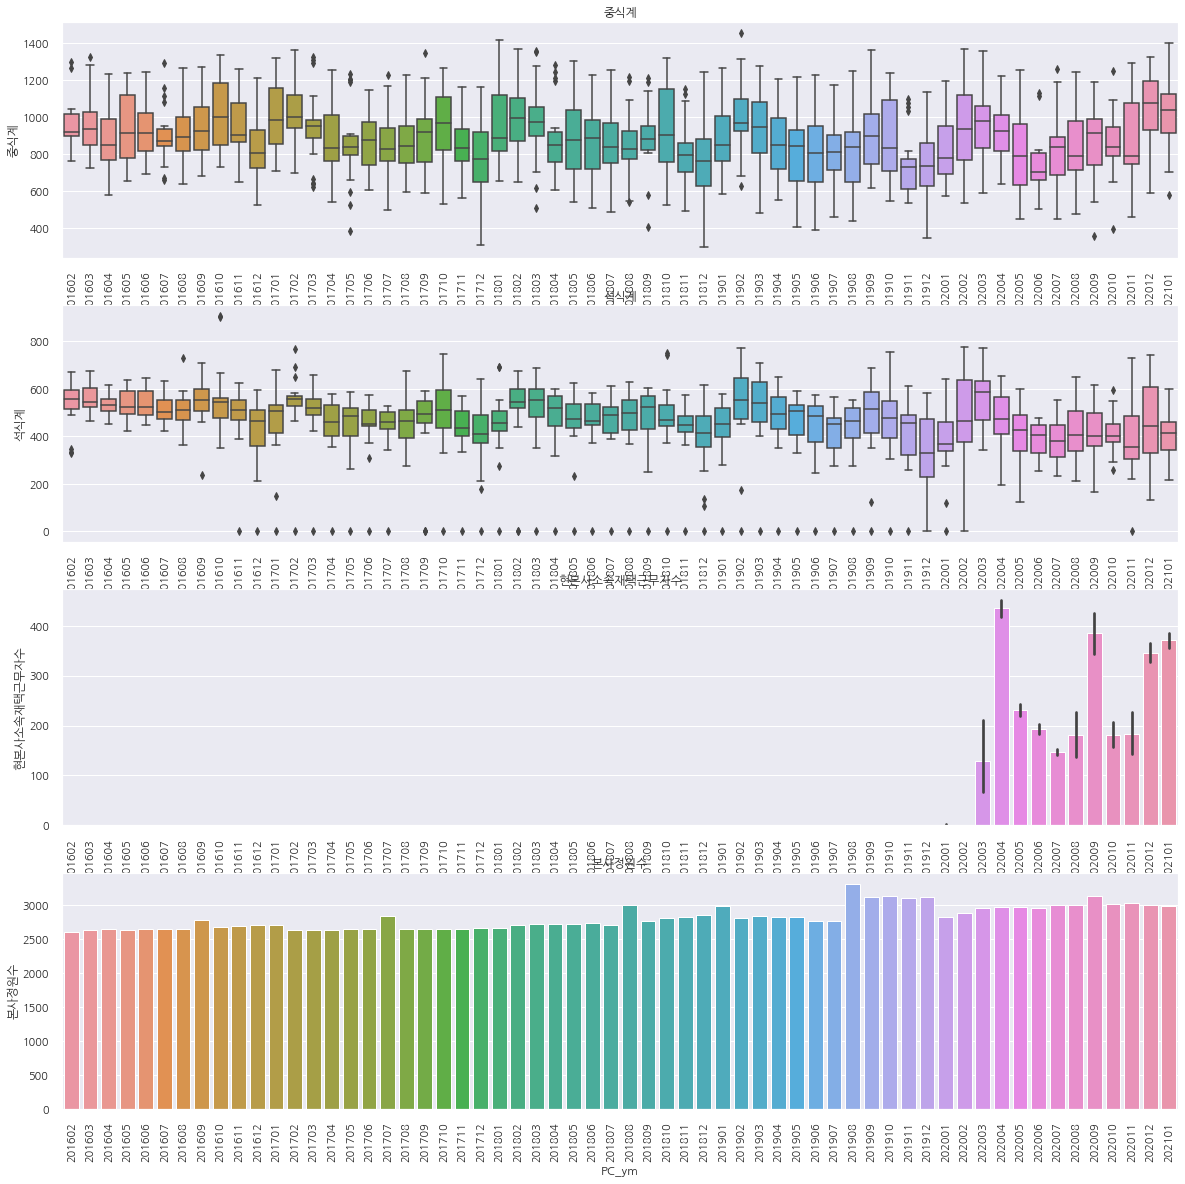

In [19]:
p, axes = plt.subplots(4,1, figsize=(20,20))

box = sns.boxplot(x='PC_ym',y='중식계', data = train_test.iloc[:train.shape[0]], ax=axes[0])
axes[0].set_title('중식계')
for item in box.get_xticklabels():
    item.set_rotation(90)
#----------------------------------------------------
box = sns.boxplot(x='PC_ym',y='석식계', data = train_test.iloc[:train.shape[0]], ax=axes[1])
axes[1].set_title('석식계')
for item in box.get_xticklabels():
    item.set_rotation(90)
#----------------------------------------------------  
# box = sns.boxplot(x='PC_ym',y='현본사소속재택근무자수', data = train_test.iloc[:train.shape[0]], ax=axes[2])
# axes[2].set_title('현본사소속재택근무자수')
# for item in box.get_xticklabels():
#     item.set_rotation(90)
#---------------------------------------------------- 
box = sns.barplot(x='PC_ym',y='현본사소속재택근무자수', data = train_test.iloc[:train.shape[0]], ax=axes[2])
axes[2].set_title('현본사소속재택근무자수')
for item in box.get_xticklabels():
    item.set_rotation(90)
#---------------------------------------------------- 
box = sns.barplot(x='PC_ym',y='본사정원수', data = train_test.iloc[:train.shape[0]], ax=axes[3])
axes[3].set_title('본사정원수')
for item in box.get_xticklabels():
    item.set_rotation(90)
    
#----------------------------------------------------     
train_test['코로나발생'] = train_test['PC_ym'].apply(lambda x:  1 if x>=202003 else 0)
print( train_test[train_test['코로나발생']==0]['중식계'].sum(), train_test[train_test['코로나발생']==0]['석식계'].sum() )
print( train_test[train_test['코로나발생']==1]['중식계'].sum(), train_test[train_test['코로나발생']==1]['석식계'].sum() )
print( train_test[train_test['코로나발생']==0]['중식계'].mean(), train_test[train_test['코로나발생']==0]['석식계'].mean() )
print( train_test[train_test['코로나발생']==1]['중식계'].mean(), train_test[train_test['코로나발생']==1]['석식계'].mean() )

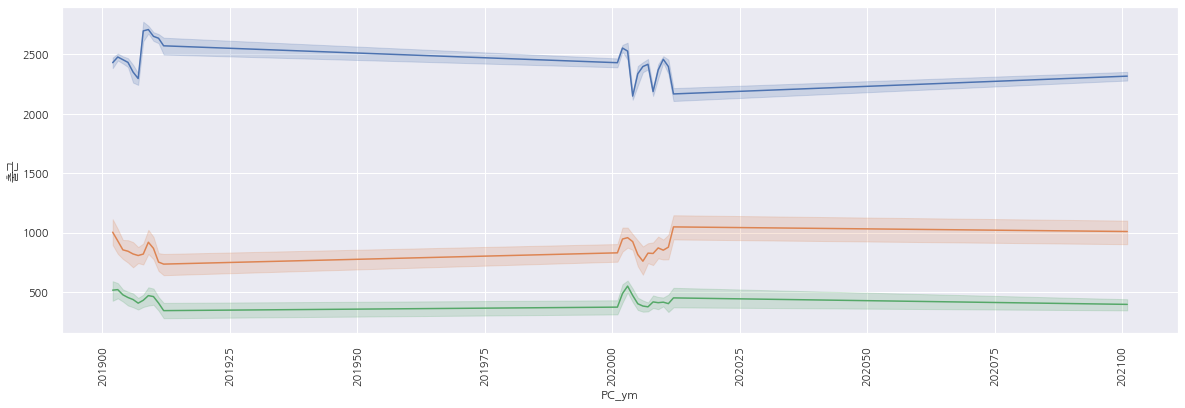

In [20]:
temp = train_test.iloc[:train.shape[0]]
temp = temp[temp['PC_ym']>201901]
p, axes = plt.subplots(figsize=(20,6))
box = sns.lineplot(x='PC_ym',y='출근', data = temp)
box = sns.lineplot(x='PC_ym',y='중식계', data = temp)
box = sns.lineplot(x='PC_ym',y='석식계', data = temp)
for item in box.get_xticklabels():
    item.set_rotation(90)

              중식계         석식계
코로나발생                        
0      890.092369  468.881526
1      891.488038  427.894737
------------------------------------------------------------------------------------------
       중식계  석식계
코로나발생          
0      996  996
1      209  209
------------------------------------------------------------------------------------------


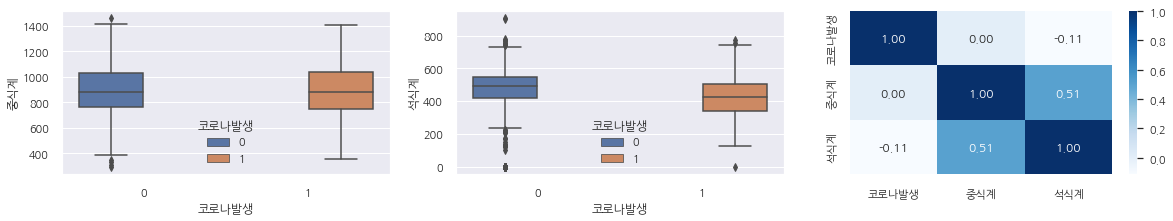

In [21]:
print(train_test.iloc[:train.shape[0]].groupby(by=['코로나발생'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['코로나발생'])[['중식계','석식계']].count())
print("---"*30)

p, axes = plt.subplots(1,3, figsize=(20,3))
sns.boxplot(x='코로나발생', y='중식계', data=train_test.iloc[:train.shape[0]], hue="코로나발생", ax=axes[0])
sns.boxplot(x='코로나발생', y='석식계', data=train_test.iloc[:train.shape[0]], hue="코로나발생", ax=axes[1])
sns.heatmap(train_test.iloc[:train.shape[0]][['코로나발생','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[2])

plt.show()


* 코로나발생 여부는 중식계, 석식계에 영향력이 없다
* 중식계, 석식계의와의 상관도도 높지않다.
* <font color=red>코로나발생 : drop</font>

### 코로나 발생 전/후 요일 별 중식계


PC_w
0    197
1    198
2    197
3    202
4    202
Name: 중식계, dtype: int64
PC_w
0    43
1    42
2    42
3    42
4    40
Name: 중식계, dtype: int64


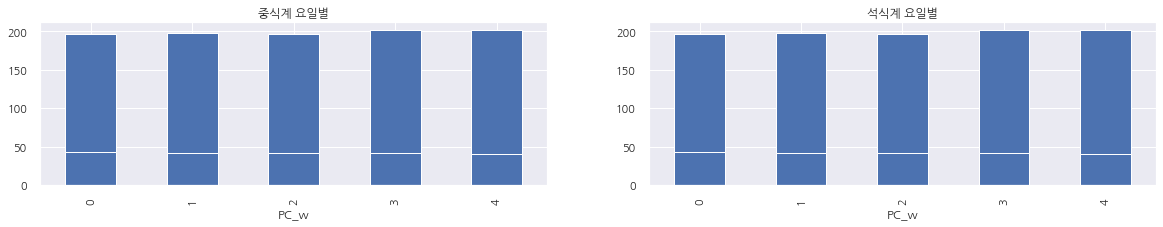

In [22]:
temp = train_test.iloc[:train.shape[0]]

print(temp[temp['코로나발생']==0].groupby('PC_w')['중식계'].count())
print(temp[temp['코로나발생']==1].groupby('PC_w')['중식계'].count())

p, axes = plt.subplots(1,2, figsize=(20,3))
# sns.barplot(x='PC_w', y='중식계', data=temp, hue='코로나발생', ax=axes[0])
temp[temp['코로나발생']==0].groupby('PC_w')['중식계'].count().sort_index().plot(kind='bar', ax=axes[0])
temp[temp['코로나발생']==1].groupby('PC_w')['중식계'].count().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title("중식계 요일별")

temp[temp['코로나발생']==0].groupby('PC_w')['석식계'].count().sort_index().plot(kind='bar', ax=axes[1])
temp[temp['코로나발생']==1].groupby('PC_w')['석식계'].count().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title("석식계 요일별")
plt.show()

## 공휴일 관련 영향도 분석

### 캘린더 생성

서비스 URL: http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/{서비스오퍼레이션}
<pre>
서비스	종류		오퍼레이션명
-----	------	--------------
국경일 정보조회	getHoliDeInfo	01: 국경일 (ex: 어린이날, 광복절, 개천절)
공휴일 정보조회	getRestDeInfo
기념일 정보조회	getAnniversaryInfo	02: 기념일 (ex: 의병의 날, 정보보호의 날, 4/19 혁명 기념일)
24절기 정보조회	get24DivisionsInfo	03: 24절기 (ex: 청명, 경칩, 하지)
잡절   정보조회	getSundryDayInfo	04: 잡절 (ex: 단오, 한식)
</pre>

In [23]:
# ! pip install BeautifulSoup4

In [24]:
import requests
from urllib import parse
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

def get_holiday(syear=2016, eyear=2021 ) :
    api_key_utf8 = "pLlZwGigTf4euiGFUdQ7ktJfpWwXA5CiHJPPtfQgwx45SHhTgIiEjF4k72HaTqHiet8qB%2F0JYw1XYOUH%2FKlRSw%3D%3D"
    api_key_decode = parse.unquote(api_key_utf8)
    operation_name_list =['getRestDeInfo'] #,'getHoliDeInfo getAnniversaryInfo','get24DivisionsInfo','getSundryDayInfo']
    
    item_list = []
    for holiday_type in operation_name_list:
        url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/" + holiday_type
        for year in np.arange(syear, eyear+1) : 
            params = {
                "ServiceKey": api_key_decode,
                "solYear": year,
                "numOfRows": 100
            }

            response = requests.get(url, params=params)
            xml = BeautifulSoup(response.text, "lxml")
            items = xml.find('items')
            item_dict = {}
            for item in items:
                item_dict = {
                    "날짜": datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d'),
                    "휴일여부": item.find("isholiday").text.strip(),
                    "종류" : item.find("datekind").text.strip(),
                    "이름":  item.find("datename").text.strip()
                }
                item_list.append(item_dict)
            res_df = pd.DataFrame(item_list)
            res_df = res_df.fillna('')
            res_df['휴일여부'].replace('Y', 1, inplace=True)
            res_df['휴일여부'].replace('N', 0, inplace=True)
            res_df['휴일여부'].fillna(0)
            res_df['휴일여부'] = res_df['휴일여부'].astype('int')
            # res_df['휴일여부'] = res_df['일자'].apply(lambda x:  1 if x in list else 0)
    return res_df


#### min date ~ max date 날짜 전체 

In [25]:
start_date = pd.to_datetime(train_test['일자'].min())  #.year
end_date = pd.to_datetime(train_test['일자'].max())   #.year
print(start_date , end_date)
dates = pd.date_range(start_date,end_date,freq='D') 
date_df = pd.DataFrame({'날짜':dates})
print(date_df.shape)
date_df.head()

2016-02-01 00:00:00 2021-04-09 00:00:00
(1895, 1)


,날짜
0,2016-02-01
1,2016-02-02
2,2016-02-03
3,2016-02-04
4,2016-02-05


#### min date ~ max date 날짜 사이의 공휴일

In [26]:
# ! pip install lxml

In [27]:
start_year = start_date.year  #df['일자'].min()).year
end_year = end_date.year   #df['일자'].max()).year
holiday_df = get_holiday(start_year,end_year)
print(start_year, end_year, holiday_df.shape)
holiday_df.head()

2016 2021 (106, 4)


,날짜,휴일여부,종류,이름
0,2016-01-01,1,01,신정
1,2016-02-07,1,01,설날
2,2016-02-08,1,01,설날
3,2016-02-09,1,01,설날
4,2016-02-10,1,01,대체공휴일


#### 달력만들기 : 날짜 전체 , 공휴일 

In [28]:
cal_df = pd.merge(date_df, holiday_df[holiday_df['종류']=='01'][['날짜','휴일여부']] , on='날짜', how='left')
cal_df.fillna(0, inplace=True)
cal_df['휴일여부'] = cal_df['휴일여부'].astype('int')
print(cal_df.shape)
cal_df.head()

(1896, 2)


,날짜,휴일여부
0,2016-02-01,0
1,2016-02-02,0
2,2016-02-03,0
3,2016-02-04,0
4,2016-02-05,0


In [29]:
cal_df['전일휴일'] = cal_df['휴일여부'].shift(1)
cal_df['다음날휴일'] = cal_df['휴일여부'].shift(-1)
cal_df = cal_df.fillna(0)
cal_df['전일휴일']   = cal_df['전일휴일'].astype('int')
cal_df['다음날휴일'] = cal_df['다음날휴일'].astype('int')
cal_df.head(10)

,날짜,휴일여부,전일휴일,다음날휴일
0,2016-02-01,0,0,0
1,2016-02-02,0,0,0
2,2016-02-03,0,0,0
3,2016-02-04,0,0,0
4,2016-02-05,0,0,0
5,2016-02-06,0,0,1
6,2016-02-07,1,0,1
7,2016-02-08,1,1,1
8,2016-02-09,1,1,1
9,2016-02-10,1,1,0


In [30]:
csum_holiday = 0
cal_df["연속휴일수"] = 0
for i in np.arange(cal_df.shape[0]-1, 0, -1):
    if cal_df.iloc[i]['휴일여부']==1:
        csum_holiday +=1
    else :
        if cal_df.iloc[i]['다음날휴일']==1 :
            cal_df.at[i,'연속휴일수'] = csum_holiday
            csum_holiday = 0
cal_df.at[cal_df.shape[0]-1,'연속휴일수'] = 2
cal_df.head(12)

,날짜,휴일여부,전일휴일,다음날휴일,연속휴일수
0,2016-02-01,0,0,0,0
1,2016-02-02,0,0,0,0
2,2016-02-03,0,0,0,0
3,2016-02-04,0,0,0,0
4,2016-02-05,0,0,0,0
5,2016-02-06,0,0,1,4
6,2016-02-07,1,0,1,0
7,2016-02-08,1,1,1,0
8,2016-02-09,1,1,1,0
9,2016-02-10,1,1,0,0


In [31]:
print(train_test.shape)
train_test = pd.merge(train_test, cal_df , left_on='일자', right_on='날짜', how='left')
print(train_test.shape)
train_test.head(2)

(1255, 20)
(1255, 25)


,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,PC_ws,PC_ym,PC_md,출근,코로나발생,날짜,휴일여부,전일휴일,다음날휴일,연속휴일수
0,2016-02-01,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0,0,2016,2,1,0,5,201602,201,2401,0,2016-02-01,0,0,0,0
1,2016-02-02,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0,0,2016,2,2,1,5,201602,202,2378,0,2016-02-02,0,0,0,0


In [32]:
print(train_test['휴일여부'].value_counts())
print(train_test['전일휴일'].value_counts())
print(train_test['다음날휴일'].value_counts())
print(train_test['코로나발생'].value_counts())

0    1255
Name: 휴일여부, dtype: int64
0    1213
1      42
Name: 전일휴일, dtype: int64
0    1216
1      39
Name: 다음날휴일, dtype: int64
0    996
1    259
Name: 코로나발생, dtype: int64


### 연속휴일수 영향도 분석

In [33]:
train_test['연속휴일수'].value_counts()

0    1215
1      33
3       4
4       2
2       1
Name: 연속휴일수, dtype: int64

In [34]:
train_test[train_test['연속휴일수']==2]

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,PC_ws,PC_ym,PC_md,출근,코로나발생,날짜,휴일여부,전일휴일,다음날휴일,연속휴일수
1254,2021-04-09,2973,259,268,0,229.0,쌀밥/흑미밥/찰현미밥 사골우거지국 해물누룽지탕 청포묵*양념간장 비름나물고추장무침 석박지 그린샐러드*망고D,흑미밥 맑은버섯국 매운사태조림 춘권*타르타르D 열무나물무침 포기김치,NaN,NaN,0,2021,4,9,4,14,202104,409,2217,1,2021-04-09,0,0,0,2


              중식계         석식계
연속휴일수                        
0      896.077978  466.610968
1      697.424242  341.696970
3      862.000000  120.333333
4      764.500000  132.000000
------------------------------------------------------------------------------------------
        중식계   석식계
연속휴일수            
0      1167  1167
1        33    33
3         3     3
4         2     2
------------------------------------------------------------------------------------------
0    1167
1      33
3       3
4       2
Name: 연속휴일수, dtype: int64
------------------------------------------------------------------------------------------
0    48
3     1
2     1
Name: 연속휴일수, dtype: int64
------------------------------------------------------------------------------------------


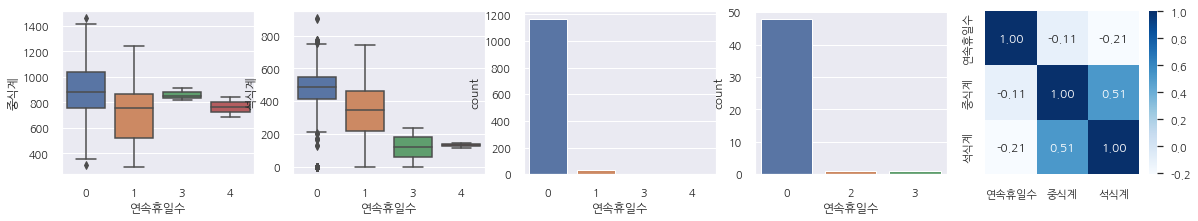

In [35]:
print(train_test.iloc[:train.shape[0]].groupby(by=['연속휴일수'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['연속휴일수'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['연속휴일수'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['연속휴일수'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='연속휴일수', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='연속휴일수', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='연속휴일수', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='연속휴일수', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['연속휴일수','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()


*  <font color='red'>연속휴일수는 석식계에 큰 영향을 준다</font>
* 그러나 train에는 [0,1,3,4]  test에는 [0,2,3] : 학습이 안된 값이 나올 수 있다. --> 예측저하
* 중식, 석식과의 상관도는 높지않다.
* <font color=red>연속휴일수 : drop</font>

### 전일휴일 영향도 분석

              중식계         석식계
전일휴일                         
0      885.742268  460.293814
1     1020.707317  503.756098
------------------------------------------------------------------------------------------
       중식계   석식계
전일휴일            
0     1164  1164
1       41    41
------------------------------------------------------------------------------------------
0    1164
1      41
Name: 전일휴일, dtype: int64
------------------------------------------------------------------------------------------
0    49
1     1
Name: 전일휴일, dtype: int64
------------------------------------------------------------------------------------------


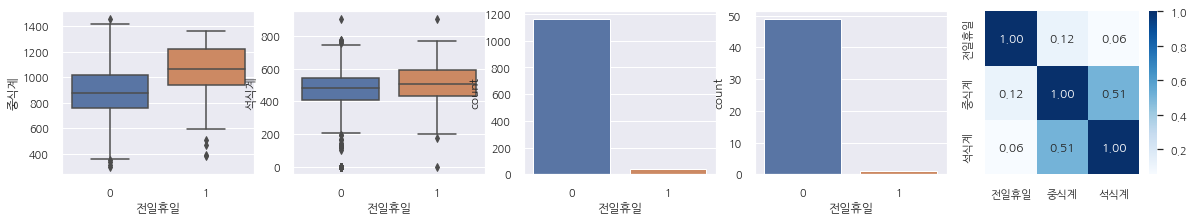

In [36]:
print(train_test.iloc[:train.shape[0]].groupby(by=['전일휴일'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['전일휴일'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['전일휴일'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['전일휴일'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='전일휴일', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='전일휴일', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='전일휴일', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='전일휴일', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['전일휴일','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()


*  <font color='red'>전일휴일은 중식계에 영향을 미친다.</font>

### 다음날휴일 영향도 분석

              중식계         석식계
다음날휴일                        
0      896.077978  466.610968
1      713.947368  313.184211
------------------------------------------------------------------------------------------
        중식계   석식계
다음날휴일            
0      1167  1167
1        38    38
------------------------------------------------------------------------------------------
0    1167
1      38
Name: 다음날휴일, dtype: int64
------------------------------------------------------------------------------------------
0    49
1     1
Name: 다음날휴일, dtype: int64
------------------------------------------------------------------------------------------


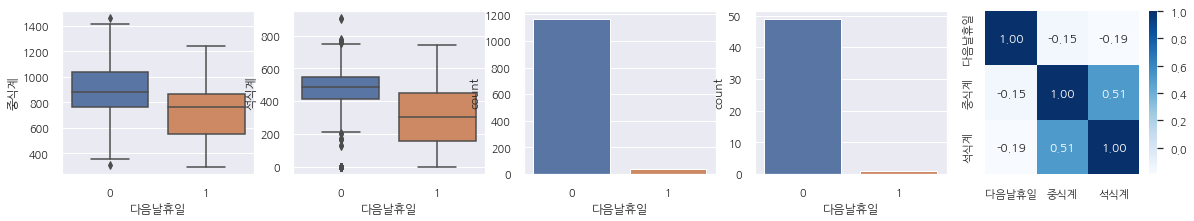

In [37]:
print(train_test.iloc[:train.shape[0]].groupby(by=['다음날휴일'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['다음날휴일'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['다음날휴일'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['다음날휴일'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='다음날휴일', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='다음날휴일', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='다음날휴일', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='다음날휴일', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['다음날휴일','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()

* <font color='red'>다음날휴일은 중식계에 영향을 미친다</font>
* <font color='red'>다음날휴일은 석식계에 많은 영향을 미친다</font>

## 자기개발의날 영향도 분석

                 중식계         석식계
자기개발의날여부                        
0         891.841788  478.063629
1         848.595238   10.666667
------------------------------------------------------------------------------------------
           중식계   석식계
자기개발의날여부            
0         1163  1163
1           42    42
------------------------------------------------------------------------------------------
0    1163
1      42
Name: 자기개발의날여부, dtype: int64
------------------------------------------------------------------------------------------
0    50
Name: 자기개발의날여부, dtype: int64
------------------------------------------------------------------------------------------


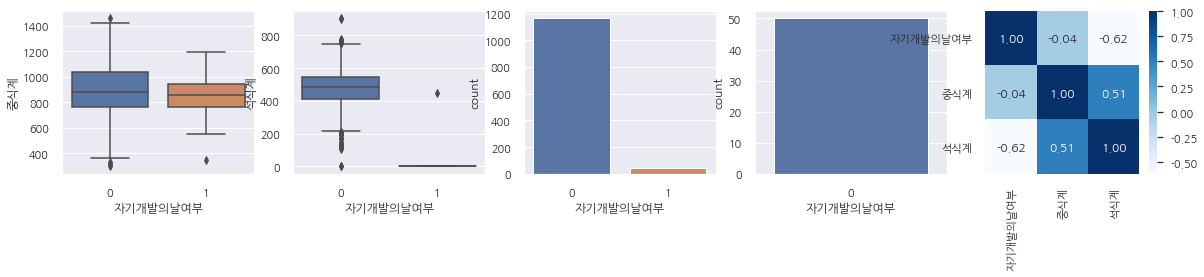

In [38]:
print(train_test.iloc[:train.shape[0]].groupby(by=['자기개발의날여부'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['자기개발의날여부'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['자기개발의날여부'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['자기개발의날여부'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='자기개발의날여부', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='자기개발의날여부', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='자기개발의날여부', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='자기개발의날여부', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['자기개발의날여부','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()

* <font color='red'>자기개발의날여부는 석식계에 <b>매우 큰</b> 영향을 준다</font>
* 그러나 train에는 [0,1] <font color='red'>test에는 [0] : 학습할 필요가 없다</font>
* 석식과의 상관도는 높다(-0.62)
* <font color=red>자기개발의날 : drop</font>

In [39]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 1254
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   본사정원수           1255 non-null   int64         
 2   본사휴가자수          1255 non-null   int64         
 3   본사출장자수          1255 non-null   int64         
 4   본사시간외근무명령서승인건수  1255 non-null   int64         
 5   현본사소속재택근무자수     1255 non-null   float64       
 6   중식메뉴            1255 non-null   object        
 7   석식메뉴            1255 non-null   object        
 8   중식계             1205 non-null   float64       
 9   석식계             1205 non-null   float64       
 10  자기개발의날여부        1255 non-null   int32         
 11  PC_y            1255 non-null   int64         
 12  PC_m            1255 non-null   int64         
 13  PC_d            1255 non-null   int64         
 14  PC_w            1255 non-null   int64         
 15  PC_w

## 중식메뉴/석식메뉴 카테고리화 

### 정규화 처리
<pre>
정규표현식
특정문자 제거            : str.replace(/\-/g,'');
앞의 공백 제거           : str.replace(/^\s+/,'');
뒤의 공백 제거          : str.replace(/\s+$/,'');
앞뒤 공백 제거          : str.replace(/^\s+|\s+$/g,'');
문자열 내의 공백 제거  : str.replace(/\s/g,'');
개행 제거                : str.replace(/\n/g,'');
엔터 제거                : str.replace(/\r/g,'');
0 제거                   : str.replace(/[^(1-9)]/gi,"");

In [40]:
def reg_exclude_(text):
    text = re.sub(r'/^\s+|\s+$/g', '', text.strip())#앞뒤 공백 제거
    text = text.replace(r' /','/')  #앞뒤 공백 제거
    text = text.replace(r'/ ','/')  #앞뒤 공백 제거

    list = text.split()
    relist = []
    for item in list:
        item = re.sub(r'\([^)]*\)', '', item.strip())               #(s) 제거
        item = re.sub(r'\/.+?$', '', item.strip())                  # /s 제거        
        item = re.sub(r'[^)]*\)', '', item.strip())                #s) 제거
        item = re.sub(r'\([^)]*', '', item.strip())                #(s 제거
        item = re.sub(r'\*[^)]*', '', item.strip())                #*s 제거
        item = re.sub(r'\&[^)]*', '', item.strip())                #&s 제거
        item = re.sub(' +', ' ', item.strip())                     #공백,탭 제거
        if len(item) > 0:
            relist.append(item)
    return ' '.join(relist)
train_test['중식메뉴2'] = train_test['중식메뉴'].apply(lambda x: reg_exclude_(x))
train_test['석식메뉴2'] = train_test['석식메뉴'].apply(lambda x: reg_exclude_(x))

In [41]:
train_test[['중식메뉴','중식메뉴2']].head(3)

,중식메뉴,중식메뉴2
0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치
1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)",쌀밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이
2,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)",카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치


In [42]:
lens = [len(row) for row in train_test['중식메뉴2'].str.split().tolist()]
print(np.unique(lens))

lens = [len(row) for row in train_test['석식메뉴2'].str.split().tolist()]
print(np.unique(lens))

[5 6 7 8]
[1 6 7 8]


In [43]:
menu_lunch  = pd.DataFrame(train_test['중식메뉴2'].str.split().tolist(), columns=["m1","m2","m3","m4","m5","m6","m7","m8"])
menu_dinner = pd.DataFrame(train_test['석식메뉴2'].str.split().tolist(), columns=["m1","m2","m3","m4","m5","m6","m7","m8"])
print(menu_lunch.shape, menu_dinner.shape)
menu_lunch.head()

(1255, 8) (1255, 8)


,m1,m2,m3,m4,m5,m6,m7,m8
0,쌀밥,오징어찌개,쇠불고기,계란찜,청포묵무침,요구르트,포기김치,None
1,쌀밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,요구르트,배추겉절이,None
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,요구르트,포기김치,None
3,쌀밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,요구르트,포기김치,None
4,쌀밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,요구르트,포기김치,None


### 메뉴 대략 통일
* 밥:13 / 국:135 / 메인메뉴:201

In [44]:
# menu[~menu['m1'].str.contains('밥')]
# df.replace(regex={r'^.라이스$': '카레라이스', ' 덮밥': '덮밥'})

print(menu_lunch['m1'].str[-2:].value_counts().sort_index().shape)
menu_lunch['m1'].str[-2:].value_counts().sort_index()

(13,)


계탕       1
곡밥       1
덮밥      45
라프       1
레밥      30
물밥      31
빔밥      55
식>       2
쌀밥    1050
양밥      12
음밥       9
이스      13
장밥       5
Name: m1, dtype: int64

In [45]:
print(menu_lunch['m2'].str[-3:].value_counts().sort_index().shape)
menu_lunch['m2'].str[-3:].value_counts().sort_index()

(135,)


각백숙     2
갈비탕     5
갈이국     6
감자국     2
감자탕     2
       ..
해물탕     1
해장국    12
홍합국     1
홍합탕     5
황태국    12
Name: m2, Length: 135, dtype: int64

In [46]:
print(menu_lunch['m3'].str[-3:].value_counts().sort_index().shape)
menu_lunch['m3'].str[-3:].value_counts().sort_index()

(201,)


갈비찜    46
겹보쌈     4
겹수육    11
고로케     1
고추전     1
       ..
피잡채     3
핫도그     1
해물전     1
향장육     4
회무침     1
Name: m3, Length: 201, dtype: int64

In [47]:
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

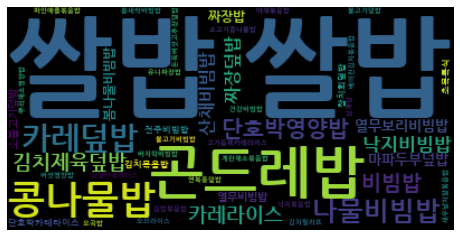

In [48]:
# p, axes = plt.subplots(1,3, figsize=(20,6))
text = " ".join(menu_lunch['m1'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

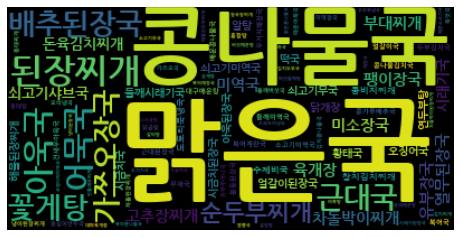

In [49]:
text = " ".join(menu_lunch['m2'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

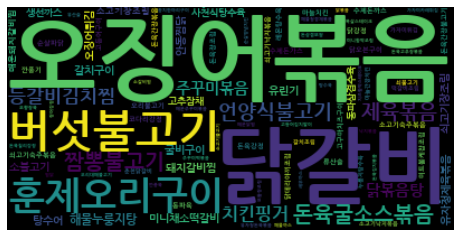

In [50]:
text = " ".join(menu_lunch['m3'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [51]:
menu_lunch_dinner = pd.DataFrame(columns=['ml_1','ml_2','ml_3','md_1','md_2','md_3'])
menu_lunch_dinner['ml_1'] = menu_lunch['m1'].str[-2:].astype('category').cat.codes
menu_lunch_dinner['ml_2'] = menu_lunch['m2'].str[-3:].astype('category').cat.codes
menu_lunch_dinner['ml_3'] = menu_lunch['m3'].str[-3:].astype('category').cat.codes  

menu_lunch_dinner['md_1'] = menu_dinner['m1'].str[-2:].astype('category').cat.codes
menu_lunch_dinner['md_2'] = menu_dinner['m2'].str[-3:].astype('category').cat.codes
menu_lunch_dinner['md_3'] = menu_dinner['m3'].str[-3:].astype('category').cat.codes      

In [52]:
train_test = pd.concat([train_test, menu_lunch_dinner], axis=1)
print(train_test.shape)
train_test.info()

(1255, 33)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 1254
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   본사정원수           1255 non-null   int64         
 2   본사휴가자수          1255 non-null   int64         
 3   본사출장자수          1255 non-null   int64         
 4   본사시간외근무명령서승인건수  1255 non-null   int64         
 5   현본사소속재택근무자수     1255 non-null   float64       
 6   중식메뉴            1255 non-null   object        
 7   석식메뉴            1255 non-null   object        
 8   중식계             1205 non-null   float64       
 9   석식계             1205 non-null   float64       
 10  자기개발의날여부        1255 non-null   int32         
 11  PC_y            1255 non-null   int64         
 12  PC_m            1255 non-null   int64         
 13  PC_d            1255 non-null   int64         
 14  PC_w            1255 non-null   int64        

## 식당 휴업
* 2020년.06.15 ~ 2020.06.30
<pre>
['2018-09-27', '2018-09-28', '2018-10-01', '2018-10-02','2018-10-04', '2018-10-05', 
 '2019-10-01', 
 '2020-06-15','2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
 '2020-06-26', '2020-06-29','2020-06-30', '2020-09-29','2020-12-28', '2020-12-29','2020-12-30', '2020-12-31']

## 타켓피쳐 로그변환

In [53]:
train_test.shape

(1255, 33)

### 중식계/석식계 이상치

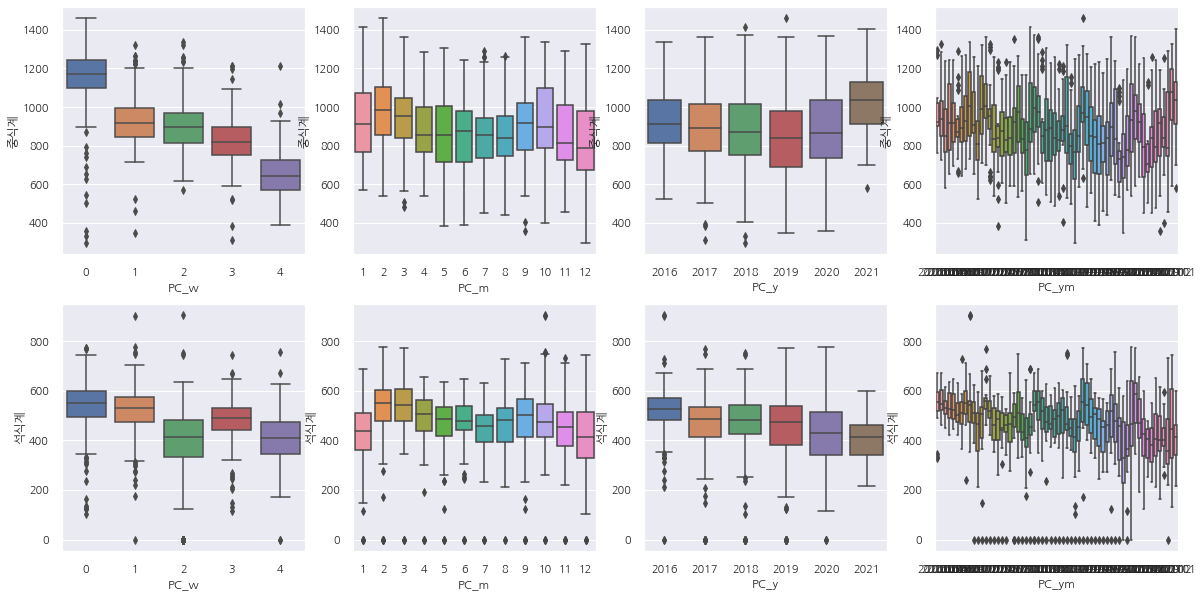

In [54]:
temp = train_test.iloc[:train.shape[0]].copy()
p, axes = plt.subplots(2,4, figsize=(20,10)) 
# 요일 월 년 월년 - 중식계 간 관계
sns.boxplot(temp['PC_w'], temp['중식계'], ax=axes[0][0])
sns.boxplot(temp['PC_m'], temp['중식계'], ax=axes[0][1])
sns.boxplot(temp['PC_y'], temp['중식계'], ax=axes[0][2])
sns.boxplot(temp['PC_ym'], temp['중식계'], ax=axes[0][3])

# 요일 월 년 월년 - 석식계 간 관계
sns.boxplot(temp['PC_w'], temp['석식계'], ax=axes[1][0])
sns.boxplot(temp['PC_m'], temp['석식계'], ax=axes[1][1])
sns.boxplot(temp['PC_y'], temp['석식계'], ax=axes[1][2])
sns.boxplot(temp['PC_ym'], temp['석식계'], ax=axes[1][3])
plt.show()


<pre>
* 석식계가 0인 날이 존재한다.
   매달 - 화, 수, 금 요일 중 석식이 0이다
   2020년 코로나 발병 이후 석식계가 0인날은 없다  
* 코로나 발병(2020-02) 기준으로 변화
   중식계가 늘었다
   석식계가 줄었다
* 이상치가 존재한다
  중식계 > 1400   , 석식계=0 ,  석식계>800

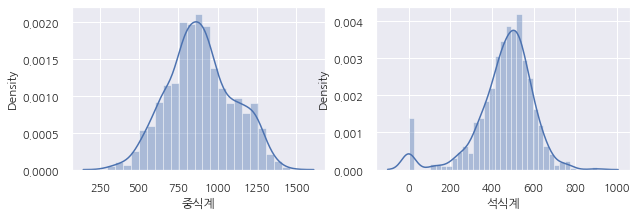

In [55]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(train_test['중식계'], label="중식계", ax=axes[0])
sns.distplot(train_test['석식계'], label="석식계", ax=axes[1])
plt.show()

In [56]:
train_test[['중식계','석식계']].describe()

,중식계,석식계
count,1205.000000,1205.000000
mean,890.334440,461.772614
std,209.505057,139.179202
min,296.000000,0.000000
25%,758.000000,406.000000
50%,879.000000,483.000000
75%,1032.000000,545.000000
max,1459.000000,905.000000


In [57]:
drop_row_idx = temp[(train_test['중식계']>=1400) | (train_test['석식계']>=800)].index
print(drop_row_idx)
temp[(train_test['중식계']>=1400) | (train_test['석식계']>=800)].shape[0]

Int64Index([163, 164, 490, 735, 1188], dtype='int64')


5

In [58]:
print(train_test.shape)
train_test = train_test.drop(drop_row_idx, axis=0)
train_test.shape

(1255, 33)


(1250, 33)

#### 이상치 제거 후 

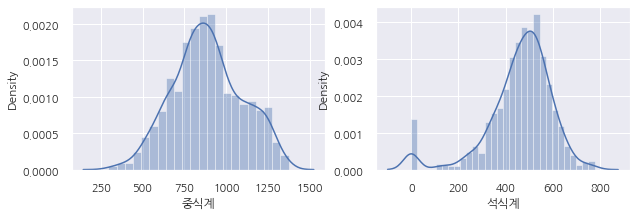

In [59]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(train_test['중식계'], label="중식계", ax=axes[0])
sns.distplot(train_test['석식계'], label="석식계", ax=axes[1])
plt.show()

* 조금 더 정규화됨
<pre>
제거 전 : 중식계		석식계
  mean	890.334440	461.772614
   std	209.505057	139.179202
제거 후 : 중식계		석식계
  mean	888.311667	460.475000
   std	207.529476	137.788446
   
<font color=red>자기개발의 날은 test에는 없다
즉, 석식계 0인날도 drop??????

In [60]:
train_test[['중식계','석식계']].describe()

,중식계,석식계
count,1200.000000,1200.000000
mean,888.311667,460.475000
std,207.529476,137.788446
min,296.000000,0.000000
25%,757.750000,405.750000
50%,878.000000,482.500000
75%,1029.250000,544.000000
max,1372.000000,776.000000


### 중식계/석식계 로그변환

In [61]:
train_test['중식계2'] = np.log1p(train_test["중식계"])
train_test['석식계2'] = np.log1p(train_test["석식계"])

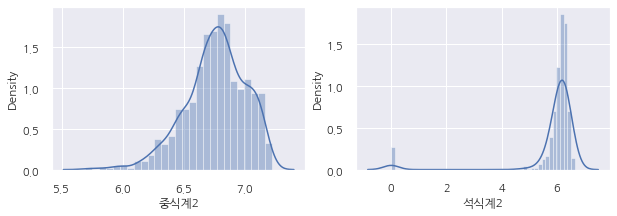

In [62]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(train_test['중식계2'], label="중식계2", ax=axes[0])
sns.distplot(train_test['석식계2'], label="석식계2", ax=axes[1])
plt.show()

#### 로그변환 후
* 로그 변환 후 정규화 안좋아짐, 왜도가 보임 --> 로그변환 drop

In [63]:
train_test = train_test.drop(['중식계2','석식계2'], axis=1)

In [64]:
train_test.shape

(1250, 33)

## 불필요한 컬럼 삭제
<pre>
  인덱스 : '일자', 
  삭제   : '본사정원수', '연속휴일수',  'PC_ym', 'PC_md',  'PC_ws','날짜', '휴일여부', '중식메뉴', '석식메뉴'
           '중식메뉴2', '석식메뉴2'	
  공통   : '출근', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
           'PC_y', 'PC_m', 'PC_w',    ('PC_d', --by 허강호)
           
          '코로나발생' ????
  중식계 : '전일휴일',       ('다음날휴일', )??
  석식계 : '자기개발의날여부', '다음날휴일', 
 
  타겟   : '중식계', '석식계',

In [65]:
# print(train_test.columns)
#train_test = train_test.drop(['PC_ym','PC_md'], axis=1)

In [66]:
train_test = train_test.set_index('일자')
train_test = train_test.drop(['본사정원수', '중식메뉴', '석식메뉴', '중식메뉴2', '석식메뉴2', '연속휴일수', 'PC_ym', 'PC_md', 'PC_ws', '날짜', '휴일여부'], axis=1)
train_test.head()

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,출근,코로나발생,전일휴일,다음날휴일,ml_1,ml_2,ml_3,md_1,md_2,md_3
일자,,,,,,,,,,,,,,,,,,,,,
2016-02-01,50,150,238,0.0,1039.0,331.0,0,2016,2,1,0,2401,0,0,0,8,92,89,19,104,139
2016-02-02,50,173,319,0.0,867.0,560.0,0,2016,2,2,1,2378,0,0,0,8,123,76,15,94,156
2016-02-03,56,180,111,0.0,1017.0,573.0,0,2016,2,3,2,2365,0,0,0,2,107,183,19,116,21
2016-02-04,104,220,355,0.0,978.0,525.0,0,2016,2,4,3,2277,0,0,0,8,18,75,3,99,118
2016-02-05,278,181,34,0.0,925.0,330.0,0,2016,2,5,4,2142,0,0,0,8,44,114,19,111,33


In [67]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1250 entries, 2016-02-01 to 2021-04-09
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   본사휴가자수          1250 non-null   int64  
 1   본사출장자수          1250 non-null   int64  
 2   본사시간외근무명령서승인건수  1250 non-null   int64  
 3   현본사소속재택근무자수     1250 non-null   float64
 4   중식계             1200 non-null   float64
 5   석식계             1200 non-null   float64
 6   자기개발의날여부        1250 non-null   int32  
 7   PC_y            1250 non-null   int64  
 8   PC_m            1250 non-null   int64  
 9   PC_d            1250 non-null   int64  
 10  PC_w            1250 non-null   int64  
 11  출근              1250 non-null   int64  
 12  코로나발생           1250 non-null   int64  
 13  전일휴일            1250 non-null   int32  
 14  다음날휴일           1250 non-null   int32  
 15  ml_1            1250 non-null   int8   
 16  ml_2            1250 non-null   int16  
 17  ml_3           

## 백업용 저장

In [68]:
train_test.to_csv("가공완료_ver03.csv", index=False)

In [69]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1250 entries, 2016-02-01 to 2021-04-09
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   본사휴가자수          1250 non-null   int64  
 1   본사출장자수          1250 non-null   int64  
 2   본사시간외근무명령서승인건수  1250 non-null   int64  
 3   현본사소속재택근무자수     1250 non-null   float64
 4   중식계             1200 non-null   float64
 5   석식계             1200 non-null   float64
 6   자기개발의날여부        1250 non-null   int32  
 7   PC_y            1250 non-null   int64  
 8   PC_m            1250 non-null   int64  
 9   PC_d            1250 non-null   int64  
 10  PC_w            1250 non-null   int64  
 11  출근              1250 non-null   int64  
 12  코로나발생           1250 non-null   int64  
 13  전일휴일            1250 non-null   int32  
 14  다음날휴일           1250 non-null   int32  
 15  ml_1            1250 non-null   int8   
 16  ml_2            1250 non-null   int16  
 17  ml_3           

In [70]:
train_test.isna().sum()

본사휴가자수             0
본사출장자수             0
본사시간외근무명령서승인건수     0
현본사소속재택근무자수        0
중식계               50
석식계               50
자기개발의날여부           0
PC_y               0
PC_m               0
PC_d               0
PC_w               0
출근                 0
코로나발생              0
전일휴일               0
다음날휴일              0
ml_1               0
ml_2               0
ml_3               0
md_1               0
md_2               0
md_3               0
dtype: int64

# 학습 & 평가 (1차)

## train_test 분리
<pre>
* 중식계 데이터
   train_lunch.shape,  test_lunch.shape, y_lunch.shape   : (1200, 14) (55, 14) (1200,)
* 석식계 데이터
   train_dinner.shape, test_dinner.shape, y_dinner.shape : (1200, 15) (55, 15) (1200,)

In [71]:
train_test.shape[0], train_test['중식계'].notna().sum(), train_test['중식계'].isna().sum()

(1250, 1200, 50)

In [72]:
train_size = train_test['중식계'].notna().sum()
col_lunch = ['PC_y', 'PC_m', 'PC_d', 'PC_w', 
          '출근', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
          '코로나발생', '전일휴일', 'ml_1', 'ml_2', 'ml_3']                  #---- 중식계 주요 피쳐


col_dinner = ['PC_y', 'PC_m', 'PC_d', 'PC_w', 
       '출근', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
        '코로나발생', '다음날휴일','자기개발의날여부','md_1', 'md_2', 'md_3']  #---- 석식계 주요 피쳐

train_lunch = train_test[col_lunch].iloc[:train_size]
test_lunch  = train_test[col_lunch].iloc[train_size:]
y_lunch     = train_test.iloc[:train_size]['중식계']

train_dinner = train_test[col_dinner].iloc[:train_size]
test_dinner  = train_test[col_dinner].iloc[train_size:]
y_dinner     = train_test.iloc[:train_size]['석식계']
print(train_lunch.shape, test_lunch.shape, y_lunch.shape)
print(train_dinner.shape, test_dinner.shape, y_dinner.shape)

(1200, 14) (50, 14) (1200,)
(1200, 15) (50, 15) (1200,)


In [73]:
train_lunch.head(2)

,PC_y,PC_m,PC_d,PC_w,출근,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,코로나발생,전일휴일,ml_1,ml_2,ml_3
일자,,,,,,,,,,,,,,
2016-02-01,2016,2,1,0,2401,50,150,238,0.0,0,0,8,92,89
2016-02-02,2016,2,2,1,2378,50,173,319,0.0,0,0,8,123,76


In [74]:
y_lunch[:2]

일자
2016-02-01    1039.0
2016-02-02     867.0
Name: 중식계, dtype: float64

In [75]:
train_dinner.head(2)

,PC_y,PC_m,PC_d,PC_w,출근,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,코로나발생,다음날휴일,자기개발의날여부,md_1,md_2,md_3
일자,,,,,,,,,,,,,,,
2016-02-01,2016,2,1,0,2401,50,150,238,0.0,0,0,0,19,104,139
2016-02-02,2016,2,2,1,2378,50,173,319,0.0,0,0,0,15,94,156


In [76]:
y_dinner.head()

일자
2016-02-01    331.0
2016-02-02    560.0
2016-02-03    573.0
2016-02-04    525.0
2016-02-05    330.0
Name: 석식계, dtype: float64

## 모델 탐색 (pycaret) 
* ref : https://pycaret.readthedocs.io/en/latest/api/regression.html
* ref : https://pycaret.readthedocs.io/en/latest/api/classification.html
* ref : https://towardsdatascience.com/introduction-to-regression-in-python-with-pycaret-d6150b540fc4

---------- 
<pre>
reg = setup(data=X1,
            target='중식계',
            train_size: 0.8,  #default = 0.7
            imputation_type: 'simple',    #‘iterative’         iterative_imputation_iters: 5,  
            ignore_features: [],
            data_split_shuffle:False      #data_split_stratify: False #or list
            session_id: 1414,             #random_state
            fold_strategy: 'kfold',       #‘stratifiedkfold’,‘groupkfold’,‘timeseries’, kcv    
            fold:10,   
            fold_shuffle:False,
            verbose: True
            
            # date_features:
            #categorical_features:    categorical_imputation:       categorical_iterative_imputer: 
            #ordinal_features:        high_cardinality_features:    high_cardinality_method:
            
            #numeric_features:      
            #numeric_imputation = 'mean',  #fillna()  'mean' or ‘median’ or 0
            #numeric_iterative_imputer: str, default = ‘lightgbm’
            
            #normalize: bool, default = False  ,  normalize_method: 'robust'  #minmax, maxabs
            #remove_outliers: bool, default = False           outliers_threshold: float, default = 0.05
            #remove_multicollinearity: False, multicollinearity_threshold: 0.9  remove_perfect_collinearity: True
            #create_clusters: bool, default = False           cluster_iter: int, default = 20
            #polynomial_features: bool, default = False       polynomial_degree: int, default = 2

--------------------------
<pre>
<font color=red>
X_lunch = pd.concat([train_lunch, y_lunch], axis=1)
from pycaret.utils import check_metric
from pycaret.datasets import get_data 
from pycaret.classification import *
from pycaret.regression import *
setup_test        = setup(data=X_lunch[:-100], target='중식계', silent= True)    # train_test_split(X,y)
rf_model          = create_model('rf', fold=5)                                  # rf_model = RandomForestRegressor()
top3_model        = compare_models(sort='mae', n_select=3)                      # ........ best mae score top3_model 

#----------------------------------------------------

#tuned_top3_model  = [tune_model(i) for i in top3_model]                      # ........ Optuna like..Hyper-parameter tunning
voting_top3_model = blend_models(estimator_list=tuned_top3_model)             # voting_top3_model = VottingRegressor(rf,lr,svc)
pred_holdout      = predict_model(voting_top3_model)                          # pred=predict(X_val)
final_model       = finalize_model(voting_top3_model)                         # ........ final_model
rf_pred           = predict_model(final_model, data=X_lunch.iloc[-100:])      # pred=predict(X_test)
rf_pred[:2]
</pre>
--------------------------------

In [77]:
from pycaret.utils import check_metric
from pycaret.datasets import get_data 
from pycaret.classification import *
from pycaret.regression import *


* train_lunch.shape, test_lunch.shape, y_lunch.shape : (1200, 14) (55, 14) (1200,)

### 중식계
* <font color=red><b>setup(data=X) , 이때 X는 KFold 처럼  X_train + y_train 데이터를 넣는다 ************** 주의</b></font>
* train_lunch.shape,  test_lunch.shape, y_lunch.shape   : (1200, 14) (55, 14) (1200,)

In [78]:
X_lunch = pd.concat([train_lunch, y_lunch], axis=1)
print(X_lunch.shape)
X_lunch.head(1)

(1200, 15)


,PC_y,PC_m,PC_d,PC_w,출근,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,코로나발생,전일휴일,ml_1,ml_2,ml_3,중식계
일자,,,,,,,,,,,,,,,
2016-02-01,2016,2,1,0,2401,50,150,238,0.0,0,0,8,92,89,1039.0


In [79]:
X_lunch.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1200 entries, 2016-02-01 to 2021-01-26
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PC_y            1200 non-null   int64  
 1   PC_m            1200 non-null   int64  
 2   PC_d            1200 non-null   int64  
 3   PC_w            1200 non-null   int64  
 4   출근              1200 non-null   int64  
 5   본사휴가자수          1200 non-null   int64  
 6   본사출장자수          1200 non-null   int64  
 7   본사시간외근무명령서승인건수  1200 non-null   int64  
 8   현본사소속재택근무자수     1200 non-null   float64
 9   코로나발생           1200 non-null   int64  
 10  전일휴일            1200 non-null   int32  
 11  ml_1            1200 non-null   int8   
 12  ml_2            1200 non-null   int16  
 13  ml_3            1200 non-null   int16  
 14  중식계             1200 non-null   float64
dtypes: float64(2), int16(2), int32(1), int64(9), int8(1)
memory usage: 123.0 KB


#### 전처리 : setup()

In [80]:
reg_lunch = setup(data=X_lunch,                            #--------------------X_train 0.8
                    target='중식계',
                    train_size=0.8,      #default = 0.7
                    imputation_type='simple',    
                    #ignore_features=[],
                    data_split_shuffle=False,     
                    session_id=1414,     #random_state
                    fold_strategy='kfold',
                    fold=10,   
                    fold_shuffle=False,
                    verbose=True, 
                    silent= True
                 )

,Description,Value
0,session_id,1414
1,Target,중식계
2,Original Data,"(1200, 15)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(960, 33)"


In [81]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPursuit,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


#### 모델생성 : create_model()

In [82]:
rf_model = create_model('rf', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,69.2933,8086.3846,89.9243,0.7091,0.1010,0.0760
1,65.5964,7708.3969,87.7975,0.8035,0.1111,0.0796
2,68.2519,7743.7681,87.9987,0.8237,0.1145,0.0826
3,75.8615,10953.9013,104.6609,0.7556,0.1470,0.1027
4,91.7951,13989.1063,118.2756,0.6876,0.1577,0.1259
Mean,74.1596,9696.3114,97.7314,0.7559,0.1263,0.0934
SD,9.4426,2464.3747,12.0369,0.0524,0.0220,0.0187


#### 모델비교 : compare_models()

In [83]:
#return Trained model depending on 'n_select'
top3_model = compare_models(sort='MAE',           #default 'R2'
                             n_select= 3,          #top-n
                             #--------
                             round=4,              #np.round(score)
                             cross_validation=True,
                             verbose=True,
                             errors='ignore'
                             #fold=None,           #n_splits’ parameter of the CV generator in the setup function.
                             #fit_kwargs: dict, default = {} (empty dict)
                            )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,65.9832,7769.6998,87.6799,0.8015,0.1103,0.0814,0.9750
br,Bayesian Ridge,66.0882,7430.5332,85.9325,0.8078,0.1073,0.0806,0.0150
ridge,Ridge Regression,66.0957,7429.8157,85.9312,0.8075,0.1073,0.0806,0.0040
lr,Linear Regression,66.1684,7441.0169,85.9973,0.8069,0.1074,0.0807,0.0160
lasso,Lasso Regression,67.2298,7647.0673,87.0591,0.8047,0.1085,0.0821,0.0050
gbr,Gradient Boosting Regressor,68.3269,8174.4560,90.0095,0.7897,0.1140,0.0845,0.1090
lightgbm,Light Gradient Boosting Machine,69.8048,8461.5402,91.5089,0.7837,0.1142,0.0852,0.2320
rf,Random Forest Regressor,71.4151,9230.9060,95.1066,0.7664,0.1214,0.0891,0.6160
xgboost,Extreme Gradient Boosting,71.6023,9064.2157,94.5818,0.7678,0.1180,0.0877,0.6390
et,Extra Trees Regressor,71.9680,9774.3538,97.3474,0.7535,0.1242,0.0895,0.2990


#### 모델튜닝 : tune_model() 
* 모델 하이퍼파라미터 튜닝 : 상단시간 소요 주의~~~~

In [84]:
#---- 튜닝전
print(top3_model)

[<catboost.core.CatBoostRegressor object at 0x0000026D59B87AF0>, BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1414, solver='auto', tol=0.001)]


In [85]:
tuned_top3_model  = [tune_model(i) for i in top3_model]                      # ........ Optuna like..Hyper-parameter tunning

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,65.9826,8006.6707,89.4800,0.7300,0.0938,0.0734
1,59.9981,5764.8993,75.9269,0.7776,0.0845,0.0657
2,62.9685,6411.7207,80.0732,0.8340,0.0870,0.0675
3,60.4501,5712.1912,75.5790,0.8382,0.0968,0.0765
4,63.5693,6941.1354,83.3135,0.8286,0.1151,0.0822
5,75.0099,8460.0729,91.9787,0.8161,0.0991,0.0793
6,63.1272,6964.9068,83.4560,0.8230,0.1128,0.0826
7,70.6549,9172.0109,95.7706,0.8174,0.1388,0.0984
8,68.8135,7862.9595,88.6733,0.8171,0.1190,0.0901
9,72.7711,9401.2196,96.9599,0.7980,0.1279,0.0940


In [86]:
#--튜닝 후 
print(tuned_top3_model)

[<catboost.core.CatBoostRegressor object at 0x0000026D599F6CD0>, BayesianRidge(alpha_1=0.005, alpha_2=0.0001, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=0.005, lambda_2=0.1, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False), Ridge(alpha=7.88, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1414, solver='auto', tol=0.001)]


#### 학습&예측 : blend_models(), predict_model(), finalize_model()

In [87]:
# 중식계 앙상블 모델
ens_model   = blend_models(estimator_list= tuned_top3_model, #-----------top3_model 
                           fold=5, 
                           optimize='MAE',
                           round= 4,
                           verbose=True)
pred_holdout = predict_model(ens_model)                    #--------------------predict(X_val)  0.2 
final_model  = finalize_model(ens_model)
pred      = predict_model(final_model, data=test_lunch)    #--------------------predict(test)  공모전문제
print(pred['Label'].head())  


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.3269,6620.8684,81.3687,0.7618,0.0881,0.0694
1,59.3068,5748.0618,75.8160,0.8535,0.0909,0.0696
2,65.5375,7098.3413,84.2517,0.8384,0.1058,0.0776
3,67.3615,8200.1203,90.5545,0.8171,0.1285,0.0919
4,68.6692,8199.6668,90.5520,0.8169,0.1159,0.0891
Mean,64.6404,7173.4117,84.5086,0.8175,0.1058,0.0795
SD,3.4129,943.3867,5.6314,0.0311,0.0152,0.0095


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,653.2387,635793.8588,797.3668,-12.1195,1.3044,0.7345


일자
2021-01-27     985.781185
2021-01-28     887.247657
2021-01-29     636.975411
2021-02-01    1290.131944
2021-02-02    1063.827259
Name: Label, dtype: float64


In [88]:
submit["중식계"] = pred["Label"].values
submit.head()

,일자,중식계,석식계
0,2021-01-27,985.781185,0
1,2021-01-28,887.247657,0
2,2021-01-29,636.975411,0
3,2021-02-01,1290.131944,0
4,2021-02-02,1063.827259,0


In [89]:
print(rf_model)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1414, verbose=0, warm_start=False)


In [90]:
print(final_model)

VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x0000026D58F36E50>),
                            ('br',
                             BayesianRidge(alpha_1=0.005, alpha_2=0.0001,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=0.005, lambda_2=0.1,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False)),
                            ('ridge',
                             Ridge(alpha=7.88, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=1414, solver='auto',
                                   tol=0.001))],
                n_j

#### 평가점수 : check_metric()

In [91]:
# ------------- Accuracy, AUC, Recall, Precision, F1, Kappa, MCC, MAE, MSE, RMSE, R2, RMSLE, MAPE.
check_metric(pred_holdout['중식계'], pred_holdout['Label'], metric='MAE') 

653.2387

#### 평가결과 시각화 (optional)
* ref : https://www.kaggle.com/resilientmax/simple-preprocessing-and-pycaret-demonstration

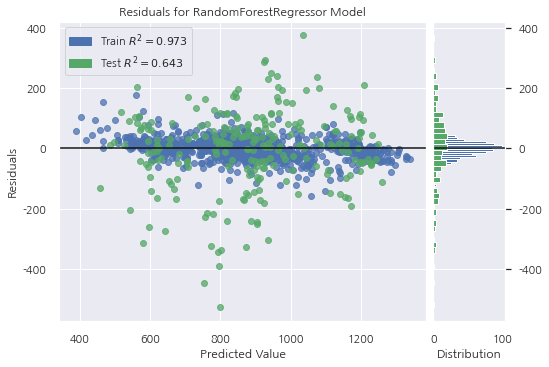

In [92]:
#---- 결정계수(R sqaured, Coefficient of Determination, R2):설명력 == 모형 적합도 평가
plot_model(rf_model)

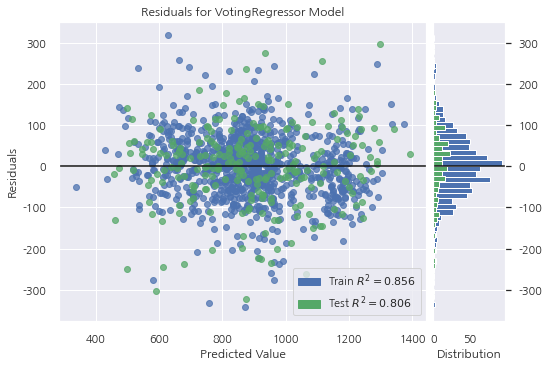

In [93]:
plot_model(final_model)

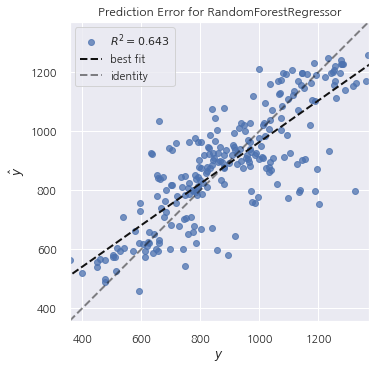

In [94]:
plot_model(rf_model,    plot = 'error')

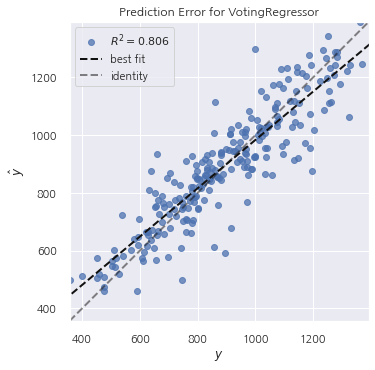

In [95]:
plot_model(final_model, plot = 'error')

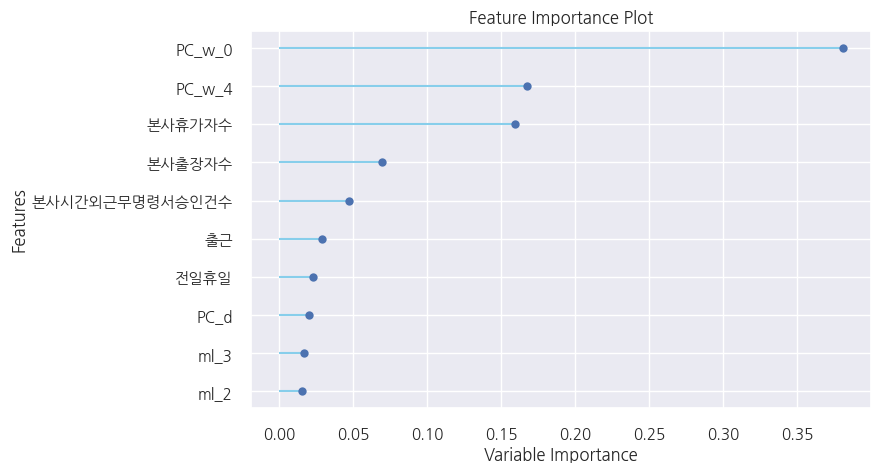

In [96]:
plot_model(rf_model,    plot='feature')

In [97]:
evaluate_model(rf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### 모델 저장 (optional)

In [98]:
save_model(final_model,'pycaret_final_model_ver01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='중식계',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='m...
                                                             alpha_init=None,
                                                             compute_score=False,
                                                             copy_X=True,
                                                             fit_intercept=True

#### 저장모델 불러오기 (optional)

In [99]:
saved_final_pycaret_model = load_model('pycaret_final_model_ver01')

#--- 예측
new_pred = predict_model(saved_final_pycaret_model, data=X_lunch.iloc[-100:])
print("MAE 점수 : ", check_metric(new_pred.중식계, new_pred.Label, 'MAE'))
print()
print(new_pred["Label"].head())

Transformation Pipeline and Model Successfully Loaded
MAE 점수 :  77.9211

일자
2020-08-24    1163.099008
2020-08-25    1035.191965
2020-08-26     951.367941
2020-08-27     937.876898
2020-08-28     707.424831
Name: Label, dtype: float64


### 석식계
 * train_dinner.shape, test_dinner.shape, y_dinner.shape : (1200, 15) (55, 15) (1200,)

In [100]:
X_dinner = pd.concat([train_dinner, y_dinner], axis=1)
print(X_dinner.shape)
X_dinner.head(1)

(1200, 16)


,PC_y,PC_m,PC_d,PC_w,출근,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,코로나발생,다음날휴일,자기개발의날여부,md_1,md_2,md_3,석식계
일자,,,,,,,,,,,,,,,,
2016-02-01,2016,2,1,0,2401,50,150,238,0.0,0,0,0,19,104,139,331.0


In [101]:
reg_dinner = setup(data=X_dinner,                           #--------------------X_train 0.8
            target='석식계',
            train_size=0.8,                                 #default = 0.7
            imputation_type='simple',    
            #ignore_features=[],
            data_split_shuffle=False,     
            session_id=1414,     #random_state
            fold_strategy='kfold',
            fold=10,   
            fold_shuffle=False,
            verbose=True, 
            silent= True
           )

,Description,Value
0,session_id,1414
1,Target,석식계
2,Original Data,"(1200, 16)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(960, 34)"


In [102]:
#return Trained model depending on 'n_select'
top3_model = compare_models(sort='MAE',           #default 'R2'
                             n_select= 3,          #top-n
                             #--------
                             round=4,              #np.round(score)
                             cross_validation=True,
                             verbose=True,
                             errors='ignore'
                             #fold=None,           #n_splits’ parameter of the CV generator in the setup function.
                             #fit_kwargs: dict, default = {} (empty dict)
                            )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,46.1909,4101.5803,63.4256,0.6758,0.6902,0.1048,0.0110
br,Bayesian Ridge,46.3205,4098.7169,63.4232,0.6750,0.7123,0.1048,0.0050
ridge,Ridge Regression,46.3881,4097.0744,63.4224,0.6745,0.7190,0.1047,0.0040
lar,Least Angle Regression,46.4268,4122.0044,63.6194,0.6745,0.6965,0.1054,0.0060
catboost,CatBoost Regressor,47.2052,4430.6057,65.7158,0.6556,0.6266,0.1074,1.0600
gbr,Gradient Boosting Regressor,47.3568,4550.2882,66.5386,0.6561,0.6084,0.1075,0.0790
et,Extra Trees Regressor,47.8688,4709.6603,67.5037,0.6430,0.3877,0.1125,0.1970
lightgbm,Light Gradient Boosting Machine,47.9621,4422.4709,65.8732,0.6359,0.5010,0.1121,0.0960
lasso,Lasso Regression,48.4392,4287.4018,64.9982,0.6599,0.7488,0.1103,0.0050
rf,Random Forest Regressor,49.8081,4849.6210,68.9523,0.6125,0.4249,0.1176,0.1980


In [103]:
# 석식계 앙상블 모델
tuned_top3_model  = [tune_model(i) for i in top3_model]    
ens_model   = blend_models(estimator_list= tuned_top3_model,   #-----------top3_model 
                           fold=5, 
                           optimize='MAE',
                           round= 4,
                           verbose=True)
pred_holdout = predict_model(ens_model)                        #--------------------predict(X_val)  0.2 
final_model  = finalize_model(ens_model)
pred = predict_model(final_model, test_dinner)                 #--------------------predict(test)  공모전문제
print(pred['Label'].head()) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,46.6181,3995.5889,63.2107,0.1841,0.1277,0.0933
1,46.3210,3265.1901,57.1418,0.8197,0.9027,0.1037
2,49.2826,5253.2867,72.4796,0.7642,1.1514,0.0962
3,46.6326,4328.5158,65.7915,0.7912,0.8274,0.1090
4,46.2621,3917.9847,62.5938,0.8077,0.8625,0.1257
Mean,47.0233,4152.1132,64.2435,0.6734,0.7743,0.1056
SD,1.1397,649.5613,4.9890,0.2454,0.3427,0.0115


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,530.7829,393923.9451,627.6336,-18.5158,1.0283,1.3653


일자
2021-01-27    357.944245
2021-01-28    416.916244
2021-01-29    292.757930
2021-02-01    558.185559
2021-02-02    516.954418
Name: Label, dtype: float64


In [104]:
submit["석식계"] = pred["Label"].values
submit.head()

,일자,중식계,석식계
0,2021-01-27,985.781185,357.944245
1,2021-01-28,887.247657,416.916244
2,2021-01-29,636.975411,292.757930
3,2021-02-01,1290.131944,558.185559
4,2021-02-02,1063.827259,516.954418


# 학습 & 평가 (2차)

## Optuna 모델 튜닝

In [105]:
# submit['중식계'] = (pred_rf['중식계'] + pred_svc['중식계']) / 2
# submit['석식계'] = (pred_rf['석식계']*0.4 + pred_svc['석식계']*0.6) 
# submit.to_csv('v01.csv', index=False)